## Goals: Training the *Final* Models

This notebook trains the model on the full *baseline_dataset* for the final prediction on evaluation data.

Here, we train a model designed to generalize across water stations in Brazil and France. However, you are not required to follow this approach and may opt to train separate models for different geographic *regions*.

This baseline model training example utilizes all available features, with hyperparameters chosen for quick execution rather than optimization. For hyperparameter tuning and feature selection explorations, refer to the `02_exploration` folder.

> **Note:** This notebook requires outputs from the `00 Preprocessing` notebooks.

<img src="../images/notebook-3.png" alt="Experiment Diagram" style="width:75%; text-align:center;" />

### 1. Data Import and Setup

This section imports the necessary libraries, sets up environment paths, and includes custom utility functions.

In [128]:
%load_ext autoreload
%autoreload 2

import os
import sys

import joblib
import numpy as np
import pandas as pd
import lightgbm as lgb
import json
import matplotlib.pyplot as plt

from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor
from quantile_forest import RandomForestQuantileRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct,ExpSineSquared, WhiteKernel,Matern, ConstantKernel as C
from sklearn.model_selection import train_test_split

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..')))

from src.utils.custom_models import VotingRandomForestQuantileRegressor
from src.utils.model import split_dataset, compare_models_per_station, XGBQRFModel, ChainedQrfModel, SpecialistQrfModel, XGBQRF_SimpleModel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


##### Constants :
- **INPUT_DIR**: Directory for input data (same as in "02 - Feature Engineering").
- **MODEL_DIR**: Directory where trained models are saved.
- **DATASET_DIR**: Directory where the Zenodo dataset is unzipped.

##### Model Parameters

- **SEED**: 42 (for reproducibility)
- **NUMBER_OF_WEEK**: 4 (one model is trained per week)

##### FINAL_MODELS

- **mapie**: Combines LightGBM with MAPIE. **MAPIE** (Model Agnostic Prediction Interval Estimator) computes prediction intervals for any regression model using conformal methods.
- **qrf**: Quantile Random Forest (natively produces prediction intervals)
- **ebm**: Explainable Boosting Machine is used as a exemple that does not natively implement prediction intervals, but that can be customised to do so.

In [129]:
INPUT_DIR = "../../../data/input/"
DATASET_DIR = "../../../dataset/"

DATASET_TRANSFORMS = [
    "rm_gnv_st",
    "pca",
    "snow_index",
    # "oh_enc_date",
    "cyc_enc_date",
    "clust_index",
    "clust_hydro",
    # "scl_feat",
    "scl_feat_wl", # Scale all except waterflow lag
    # "scl_catch",
    # "rm_wl", # remove custom generated water_flow_lag 3w & 4w ---> Need USE_CUSTOM_PREPROCESS = True
    "slct_ma", # keep only specific mobile average 2w or/and 3w or/and 4w ---> Need USE_CUSTOM_PREPROCESS = True
    "lag_slope", # add an indicator that is calculated between water_flow_lag 1w and 2w 
    # "scl_by_clust"
]

DATASET_SPEC = "_".join(DATASET_TRANSFORMS)

DATASET_SPEC = "dataset_custom_23"

MODEL_DIR = f"../../../models/{DATASET_SPEC}/"

SEED = 42
NUMBER_OF_WEEK = 4

FINAL_MODELS = [
                # "qrf_bagging",
                "qrf_voting",
                "qrf",
                # "chained_qrf",
                # "quantile_xgb_qrf",
                # "native_xgb_qrf",
                # "gbr",
                # "gpr"
                # "specialized_qrf"
                ]

gpr = {}
qrf = {}
chained_qrf = None
qrf_bagging = {}
qrf_voting = {}
gbr = {}

COLUMNS_TO_DROP = ["water_flow_week1", "water_flow_week2", "water_flow_week3", "water_flow_week4"]

USE_ONLY_BEST_FEATURES = False
USE_CORRELATED_FEATURES = True

BEST_FEATURES = [
    "precipitations_lag_1w_pca_2",
    "precipitations_pca_1",
    "precipitations_pca_2",
    "tempartures_lag_1w_pca_1",
    "tempartures_pca_1",
    "soil_moisture_pca_1",
    "soil_moisture_pca_2",
    "soil_moisture_pca_3",
    "evaporation_lag_1w_pca_1",
    "evaporation_pca_1",
    "soil_composition_pca_1",
    "soil_composition_pca_4",
    "soil_composition_pca_6",
    "soil_composition_pca_7",
    "latitude",
    "longitude",
    "catchment",
    "altitude",
    "water_flow_lag_1w",
    "water_flow_lag_2w",
    "water_flow_ma_4w_lag_1w_gauss",
    "north_hemisphere",
    "snow_index",
    "month_cos"
]

PERMANENT_FEATURES = [
    "latitude",
    "longitude",
    "altitude",
    "catchment",
    "north_hemisphere",
    "month_sin",
    "month_cos",
    "season_sin",
    "season_cos",
    "region_cluster",
    "hydro_cluster",
    # "water_flow_evolve_slope",
]

if USE_CORRELATED_FEATURES: 
    path = f"../00 Preprocessing/correlation_outputs/strong_correlations_{DATASET_SPEC}.json"

    with open(path, 'r') as file:
        correlated_features = json.load(file)


### 2. Data Loading
Load in the baseline datasets, create the directory to save models.

In [130]:
dataset_train = pd.read_csv(f"{INPUT_DIR}{DATASET_SPEC}.csv")

dataset_train = dataset_train.set_index("ObsDate")

if not os.path.exists(f"{MODEL_DIR}final/"):
    os.makedirs(f"{MODEL_DIR}final/")

Data pre-processing removal of unnecessary columns, setup of the target

In [131]:
X_train = dataset_train.drop(columns=COLUMNS_TO_DROP)
y_train = {}
for i in range(0, NUMBER_OF_WEEK):
    y_train[i] = dataset_train[f"water_flow_week{i+1}"]


### 2. Models training
#### a. QRF Bagging

In [132]:
ALPHA = 0.1
TIME_VALIDATION = "2000-01-01 00:00:00"

- **Data Preparation:**  
  - Splits `dataset_train` into training and validation subsets using `split_dataset`.
  - Removes unnecessary columns from both the training and validation datasets.
  - Extracts target variables for each week (from `water_flow_week1` to `water_flow_week4`).


In [133]:
if "qrf_bagging" in FINAL_MODELS:

    print("Training qrf_bagging")

    initial_model = RandomForestQuantileRegressor(n_estimators= 25, min_samples_split=9, min_samples_leaf=11, max_features= None, max_depth= 30, bootstrap=True)
    train_qrf_bagging, val_qrf_bagging, val_temporal  = split_dataset(dataset_train, 0.75, TIME_VALIDATION)    

    X_train_qrf_bagging = train_qrf_bagging.drop(columns=["station_code"])
    print(len(X_train_qrf_bagging.columns))
    y_train_qrf_bagging = {}
    for i in range(0, NUMBER_OF_WEEK):
        y_train_qrf_bagging[i] = train_qrf_bagging[f"water_flow_week{i+1}"]

    for i in range(NUMBER_OF_WEEK):
        print(f"Training week {i}")

        # Initialize and train Model
        qrf_bagging[i] = BaggingRegressor(estimator=initial_model, n_estimators=3, random_state=0)
        qrf_bagging[i].fit(X_train_qrf_bagging, y_train_qrf_bagging[i])
        
        # save model with date
        time = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")

        model_path = f"{MODEL_DIR}final/qrf_bagging_quantile_{time}_week_{i}.pkl"
        joblib.dump(qrf_bagging[i], model_path)


#### b. QRF Voting


In [134]:
if "qrf_voting" in FINAL_MODELS:
    print("Training qrf_voting")

    for i in range(NUMBER_OF_WEEK):
        print(f"Training week {i}")

        qrf_voting[i] = VotingRandomForestQuantileRegressor([
            "full_model_remove_station_identication",
            "france_remove_station_identication",
            "brazil_remove_station_identication",
            "full_model",
            "france_model",
            "brazil_model",
        ])

        X_train_qrf_voting = X_train.copy() 
        print(len(X_train_qrf_voting.columns))
        if USE_CORRELATED_FEATURES:
            X_train_qrf_voting = X_train_qrf_voting[PERMANENT_FEATURES + correlated_features[f"water_flow_week{i+1}"] + ["station_code"]]
            print(len(X_train_qrf_voting.columns))

        qrf_voting[i].fit(X_train_qrf_voting, y_train[i])

        time = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")
        model_path = f"{MODEL_DIR}final/qrf_voting_quantile_{time}_week_{i}.pkl"
        joblib.dump(qrf_voting[i], model_path)


Training qrf_voting
Training week 0
155
44
Training for variant full_model_remove_station_identication
Training on 27702 samples
Training for variant france_remove_station_identication
Training on 21141 samples
Training for variant brazil_remove_station_identication
Training on 6561 samples
Training for variant full_model
Training on 27702 samples
Training for variant france_model
Training on 21141 samples
Training for variant brazil_model
Training on 6561 samples
Training week 1
155
42
Training for variant full_model_remove_station_identication
Training on 27702 samples
Training for variant france_remove_station_identication
Training on 21141 samples
Training for variant brazil_remove_station_identication
Training on 6561 samples
Training for variant full_model
Training on 27702 samples
Training for variant france_model
Training on 21141 samples
Training for variant brazil_model
Training on 6561 samples
Training week 2
155
31
Training for variant full_model_remove_station_identication

#### c. GradientBoostingRegressor

In [135]:
if "gbr" in FINAL_MODELS:
    gbr = {}
    X_train_gbr = X_train.drop(columns=["station_code"])
    print("Training GradientBoostingRegressor")

    for i in range(NUMBER_OF_WEEK):
        print(f"Training week {i}")

        gbr[i] = {}
        common_params = dict(
            learning_rate=0.05,
            n_estimators=200,
            max_depth=2,
            min_samples_leaf=9,
            min_samples_split=9,
        )
        
        for alpha in [0.05, 0.5, 0.95]:
            print(f"Training quantile {alpha}")
            gbr_model = GradientBoostingRegressor(loss="quantile", alpha=alpha, **common_params)
            key = "lower" if alpha == 0.05 else "median" if alpha == 0.5 else "upper"
            gbr[i][key] = gbr_model.fit(X_train_gbr, y_train[i])

        time = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")
        model_path = f"{MODEL_DIR}final/gbr_quantile_{time}_week_{i}.pkl"
        joblib.dump(gbr[i], model_path)

#### d. QRF 

In [136]:
X_train_qrf = X_train.copy().drop(columns=["station_code"])

if "qrf" in FINAL_MODELS:

    if USE_ONLY_BEST_FEATURES:
        print(X_train_qrf.shape)
        X_train_qrf = X_train_qrf[BEST_FEATURES]
        print(X_train_qrf.shape)

    for i in range(NUMBER_OF_WEEK):
        print(f"Training week {i}")
        # Train RandomForestQuantileRegressor
        
        # n_estimators=135, min_samples_split=27, min_samples_leaf=27, max_features=None, max_depth=30, bootstrap=True
        # n_estimators=85, min_samples_split=80, min_samples_leaf=15, max_features=None, max_depth=13, bootstrap=True
        # n_estimators=25, min_samples_split=11, min_samples_leaf=27, max_features=None, max_depth=48, bootstrap=True
        
        X_train_qrf =  X_train.drop(columns=["station_code"])
        print(len(X_train_qrf.columns))
        if USE_CORRELATED_FEATURES:
            X_train_qrf = X_train_qrf[PERMANENT_FEATURES + correlated_features[f"water_flow_week{i+1}"]]
            print(len(X_train_qrf.columns))
        
        qrf[i] = RandomForestQuantileRegressor(n_estimators=25, min_samples_split=11, min_samples_leaf=27, max_features=None, max_depth=48, bootstrap=True, random_state=SEED)
        qrf[i].fit(X_train_qrf, y_train[i])

        time = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")
        model_path = f"{MODEL_DIR}final/qrf_quantile_{time}_week_{i}.pkl"
        joblib.dump(qrf[i], model_path)

Training week 0
154
43
Training week 1
154
41
Training week 2
154
30
Training week 3
154
18


#### d.1 Chained QRF 

#### Loading params

In [137]:
if "chained_qrf" in FINAL_MODELS:
    #Loading the best parameters from the random search
    BASE_PARAM_PATH = '../02 Exploration/02 - Single model optimisation/'
    file_path = BASE_PARAM_PATH + "chained_config.json"

    with open(file_path, 'r') as file:
        optimized_params = json.load(file)

    qrf_params = {}
    qrf_features = {}

    index=0

    for key in optimized_params.keys():

        model_params = {
            key.replace('model__', ''): value
            for key, value in optimized_params[key]["best_params"].items()
            if key.startswith('model__')
        }

        qrf_params[index] = model_params
        print(optimized_params[key])
        qrf_features[index] = optimized_params[key]["features_to_train"]
        index+=1

    print(qrf_params)
    print(qrf_features)

In [138]:
if "chained_qrf" in FINAL_MODELS:

    X_train_chained_qrf = X_train.drop(columns=["station_code"])
    print("Training Chained QRF")

    quantiles = [0.05, 0.5, 0.95]
    chained_qrf = ChainedQrfModel(qrf_params=qrf_params, qrf_features=qrf_features, number_of_weeks=NUMBER_OF_WEEK)

    chained_qrf.fit(X_train_chained_qrf, y_train)

    time = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")
    model_path = f"{MODEL_DIR}final/chained_qrf_quantile_{time}_4weeks.pkl"
    joblib.dump(chained_qrf, model_path)

### d.2 Specialized QRF

In [139]:
if "specialized_qrf" in FINAL_MODELS:
    print("Training Specialized QRF")
    quantiles = [0.05, 0.5, 0.95]

    qrf_params = {
        0: {
                "n_estimators": 35,
                "min_samples_split": 60,
                "min_samples_leaf": 9,
                "max_features": None,
                "max_depth": 13,
                "bootstrap": True
        },
        1: {
                "n_estimators": 35,
                "min_samples_split": 60,
                "min_samples_leaf": 9,
                "max_features": None,
                "max_depth": 13,
                "bootstrap": True
        },
        2: {
                "n_estimators": 190,
                "min_samples_split": 105,
                "min_samples_leaf": 80,
                "max_features": "log2",
                "max_depth": 20,
                "bootstrap": False
        }
    }

    qrf_features = {
        0:  [
            "catchment",
            "water_flow_lag_1w",
            "water_flow_ma_4w_lag_1w_gauss"
        ],
        1:  [
                "precipitations_lag_1w_pca_2",
                "precipitations_pca_2",
                "tempartures_lag_1w_pca_1",
                "tempartures_pca_1",
                "soil_moisture_pca_2",
                "soil_moisture_pca_3",
                "soil_composition_pca_1",
                "soil_composition_pca_2",
                "soil_composition_pca_3",
                "soil_composition_pca_4",
                "soil_composition_pca_6",
                "soil_composition_pca_7",
                "soil_composition_pca_9",
                "latitude",
                "longitude",
                "catchment",
                "altitude",
                "water_flow_lag_1w",
                "water_flow_lag_2w",
                "water_flow_ma_4w_lag_1w_gauss",
                "month_cos",
                "season_sin",
                "hydro_cluster"
            ],
        2: [
                "soil_composition_pca_8",
                "soil_composition_pca_9",
                "catchment",
                "water_flow_lag_1w",
                "water_flow_lag_2w",
                "water_flow_ma_4w_lag_1w_gauss"
            ]
    }

    specialized_qrf = SpecialistQrfModel(
        qrf_params=qrf_params,
        qrf_features=qrf_features,
        specialized_col="region_cluster",
        number_of_weeks=NUMBER_OF_WEEK,
        number_of_clusters=10,
    )

    specialized_qrf.fit(X_train_qrf, y_train)
    time = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")
    model_path = f"{MODEL_DIR}final/specialized_qrf_quantile_{time}_4weeks.pkl"
    joblib.dump(specialized_qrf, model_path)

#### e. GPR

In [140]:
selected_kernel = [
    # "rbf",
    "dot",
    # "mattern",
    # "exp-sin",
]

X_train_gpr = X_train.drop(columns=["station_code"])
train_proportion = 0.2

if "gpr" in FINAL_MODELS:

    if "dot" in selected_kernel:
          kernel = DotProduct() * DotProduct() + WhiteKernel()
    if "rbf" in selected_kernel:
          kernel = RBF(length_scale=1.0, length_scale_bounds=(0.5, 5.0))
        #   kernel = RBF(1.0, (1e-4, 1e4)) + WhiteKernel(noise_level=1.5)
    if "mattern" in selected_kernel:
        # kernel = C(1.0, (1e-4, 1e5)) * Matern(length_scale=1.0, nu=1.5, length_scale_bounds=(1e-5, 1e4))
        kernel = Matern()
    if "exp-sin" in selected_kernel:
        kernel = ExpSineSquared()


    print(f"Using {"".join(selected_kernel)} kernel")
    
    for i in range(NUMBER_OF_WEEK):
        X_sampled, _, y_sampled, _ = train_test_split(X_train_gpr, y_train[i], train_size=train_proportion, random_state=42)
        print(f"Training on {X_sampled.shape} samples")
        print(f"Training week {i}")
        # Train GaussianProcessRegressor
        gpr[i] = GaussianProcessRegressor(kernel=kernel, random_state=42)
        gpr[i].fit(X_sampled, y_sampled)

        time = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")
        model_path = f"{MODEL_DIR}final/gpr_quantile_{"".join(selected_kernel)}_{time}_week_{i}.pkl"
        joblib.dump(gpr[i], model_path)

#### f.1 Quantile-XGB-QRF

In [141]:
if "quantile_xgb_qrf" in FINAL_MODELS:

    def get_y_train(df, number_of_weeks=NUMBER_OF_WEEK):
        y_train = {}
        df_copy = df.copy()
        for i in range(0, number_of_weeks):
            y_train[i] = df[f"water_flow_week{i+1}"]
            df_copy.drop(columns=[f"water_flow_week{i+1}"], inplace=True)
        return df_copy, y_train

    quantile_xgb_qrf_models = []
    xgb_qrf_quantiles = [ALPHA / 2, 0.5, 1 - ALPHA / 2]

    train_xgb_qrf, val_xgb_qrf, val_temporal_xgb_qrf = split_dataset(
        dataset_train, 0.75, TIME_VALIDATION
    )

    X_train_xgb_qrf, y_train_xgb_qrf = get_y_train(train_xgb_qrf.drop(columns=['station_code']))
    x_val_xgb_qrf, y_val_xgb_qrf = get_y_train(val_xgb_qrf.drop(columns=['station_code']))
    x_eval_xgb_qrf, y_eval_xgb_qrf = get_y_train(val_temporal_xgb_qrf.drop(columns=['station_code']))

    for i in range(NUMBER_OF_WEEK):
        print(f"Training XGB-QRF for week {i}")
        xgb_qrf = XGBQRFModel(
            xgb_params={
                "subsample": 0.6,
                "n_estimators": 300,
                "min_child_weight": 5,
                "max_depth": 5,
                "learning_rate": 0.05,
                "gamma": 0.1,
                "colsample_bytree": 0.8,
                },
            qrf_params={
                'n_estimators':35,
                'min_samples_split':9,
                'min_samples_leaf':11,
                'max_features':None,
                'max_depth':30,
                'bootstrap':True,
            },
            quantiles=xgb_qrf_quantiles,
        )

        xgb_qrf.fit(
            X_train_xgb_qrf,
            y_train_xgb_qrf[i],
            eval_set=[
                (
                    x_val_xgb_qrf,
                    y_val_xgb_qrf[i],
                )
            ],
        )

        quantile_xgb_qrf_models.append(xgb_qrf)

        time_str = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")
        file_path = f"{MODEL_DIR}final/quantile_xgb_qrf_{time_str}_week_{i}.pkl"
        joblib.dump(xgb_qrf, file_path)
        print(f"Saved Quantile-XGB-QRF for week {i} to {file_path}")

#### f.1 Native-XGB-QRF

In [142]:
if "native_xgb_qrf" in FINAL_MODELS:

    def get_y_train(df, number_of_weeks=NUMBER_OF_WEEK):
        y_train = {}
        df_copy = df.copy()
        for i in range(0, number_of_weeks):
            y_train[i] = df[f"water_flow_week{i+1}"]
            df_copy.drop(columns=[f"water_flow_week{i+1}"], inplace=True)
        return df_copy, y_train

    native_xgb_qrf_models = []
    xgb_qrf_quantiles = [ALPHA / 2, 0.5, 1 - ALPHA / 2]

    train_xgb_qrf, val_xgb_qrf, val_temporal_xgb_qrf = split_dataset(
        dataset_train, 0.75, TIME_VALIDATION
    )

    X_train_xgb_qrf, y_train_xgb_qrf = get_y_train(train_xgb_qrf.drop(columns=['station_code']))
    x_val_xgb_qrf, y_val_xgb_qrf = get_y_train(val_xgb_qrf.drop(columns=['station_code']))
    x_eval_xgb_qrf, y_eval_xgb_qrf = get_y_train(val_temporal_xgb_qrf.drop(columns=['station_code']))

    for i in range(NUMBER_OF_WEEK):
        print(f"Training XGB-QRF for week {i}")
        xgb_qrf = XGBQRF_SimpleModel(
            xgb_params={
                "subsample": 0.6,
                "reg_lambda": 1,
                "reg_alpha": 0.01,
                "n_estimators": 300,
                "min_child_weight": 5,
                "max_depth": 5,
                "learning_rate": 0.05,
                "gamma": 0.1,
                "colsample_bytree": 0.8,
                },
            qrf_params={
                'n_estimators': 15, 
                'min_samples_split': 25, 
                'min_samples_leaf': 35, 
                'max_features': None, 
                'max_depth': 120, 
                'bootstrap': True
            },
            quantiles=xgb_qrf_quantiles,
        )

        xgb_qrf.fit(
            X_train_xgb_qrf,
            y_train_xgb_qrf[i],
            eval_set=[
                (
                    x_val_xgb_qrf,
                    y_val_xgb_qrf[i],
                )
            ],
        )

        native_xgb_qrf_models.append(xgb_qrf)

        time_str = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")
        file_path = f"{MODEL_DIR}final/native_xgb_qrf_{time_str}_week_{i}.pkl"
        joblib.dump(xgb_qrf, file_path)
        print(f"Saved Native-XGB-QRF for week {i} to {file_path}")

### 3. Performance Evaluation on the Full Training Set

> **Note:**  
> The performance displayed here is calculated on the training set. This does not necessarily reflect the models' performance on unseen data.


In [145]:
preds = {}

if "qrf_voting" in FINAL_MODELS:
    location_confidences = [1.2, 1.5, 2]

    for confidence_value in location_confidences:
        preds[confidence_value] = {}
        for i in range(NUMBER_OF_WEEK):
            qrf_voting[i].adjust_weights(location_confidence = confidence_value)
            preds[confidence_value][i] = {}

            X_train_voting = X_train.copy()

            if USE_CORRELATED_FEATURES:
                X_train_voting = X_train_voting[PERMANENT_FEATURES + correlated_features[f"water_flow_week{i+1}"] + ["station_code"]]

            preds[confidence_value][i] = qrf_voting[i].predict(X_train_voting)
            preds[confidence_value][i]["y_true"] = y_train[i]

if "gpr" in FINAL_MODELS:
    for i in range(NUMBER_OF_WEEK):
        print(f"Predicting week {i}")
        y_pred, y_std = gpr[i].predict(X_train.drop(columns=["station_code"]), return_std=True)
        y_lower = y_pred - ((y_pred*0.6) * y_std)
        y_upper = y_pred + ((y_pred*0.6) * y_std)
        
        preds[i] = {}
        preds[i]["mean"] = y_pred
        preds[i]["lower"] = y_lower
        preds[i]["upper"] = y_upper
        preds[i]["y_true"] = y_train[i]


Predicting for full_model_remove_station_identication
Predicting for france_remove_station_identication
Predicting for brazil_remove_station_identication
Predicting for full_model
Predicting for france_model
Predicting for brazil_model
Predicting for full_model_remove_station_identication
Predicting for france_remove_station_identication
Predicting for brazil_remove_station_identication
Predicting for full_model
Predicting for france_model
Predicting for brazil_model
Predicting for full_model_remove_station_identication
Predicting for france_remove_station_identication
Predicting for brazil_remove_station_identication
Predicting for full_model
Predicting for france_model
Predicting for brazil_model
Predicting for full_model_remove_station_identication
Predicting for france_remove_station_identication
Predicting for brazil_remove_station_identication
Predicting for full_model
Predicting for france_model
Predicting for brazil_model
Predicting for full_model_remove_station_identication
Pr

Using 1.2 location confidence
Using 1.5 location confidence
Using 2 location confidence


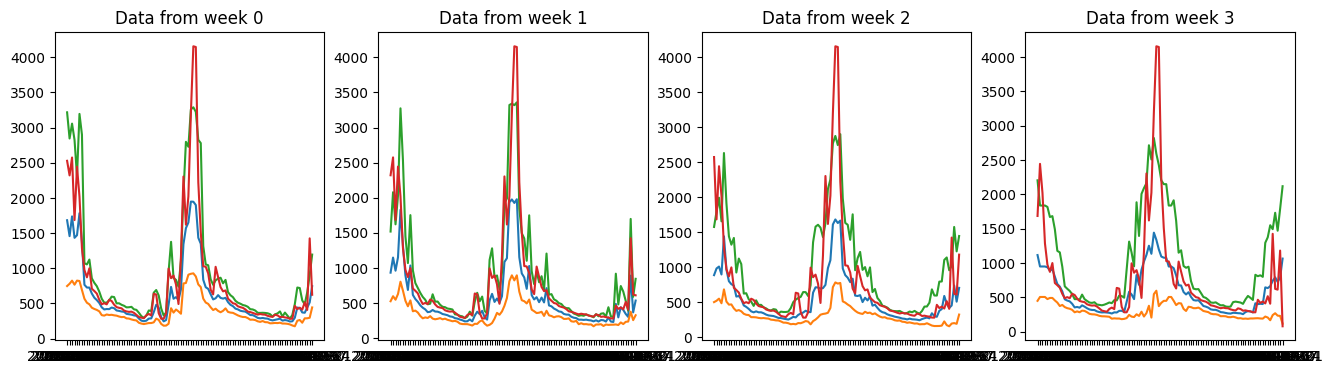

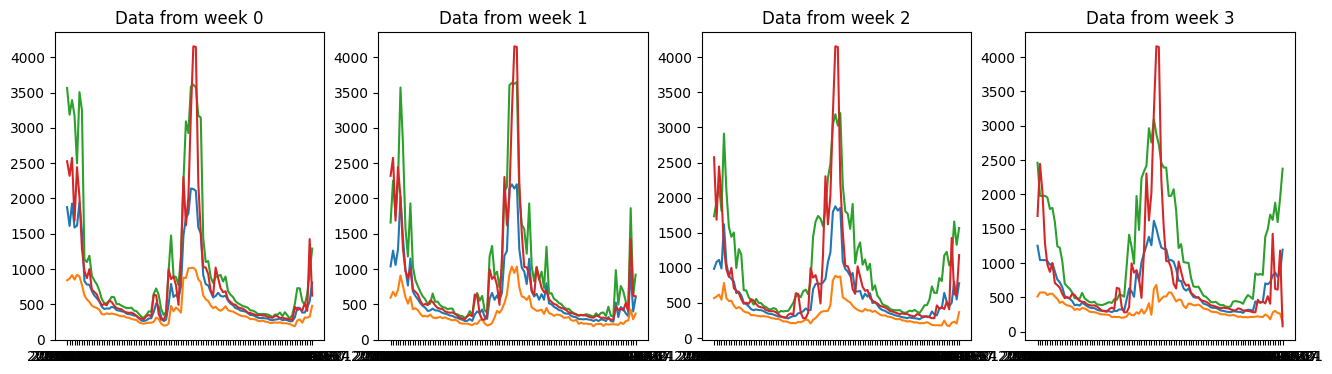

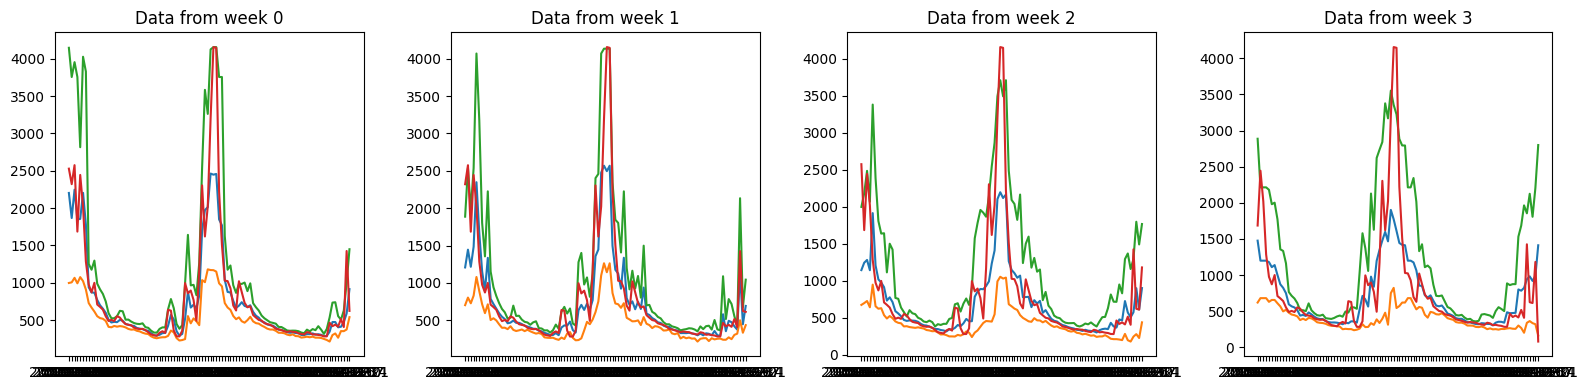

In [146]:
if "qrf_voting" in FINAL_MODELS:
    for confidence_value in location_confidences:

        fig, axes = plt.subplots(1, 4, figsize=(16, 4))

        print(f"Using {confidence_value} location confidence")

        for i in range(NUMBER_OF_WEEK):
            axes[i].plot(preds[confidence_value][i][27600:27700])
            axes[i].set_title(f"Data from week {i}")

    plt.tight_layout()  
    plt.show()

if "gpr" in FINAL_MODELS:

    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    for i in range(NUMBER_OF_WEEK):
        axes[i].plot(pd.DataFrame(preds[i])[27600:27630])
        axes[i].set_title(f"Data from week {i}")
        axes[i].legend()

    plt.tight_layout()  
    plt.show()


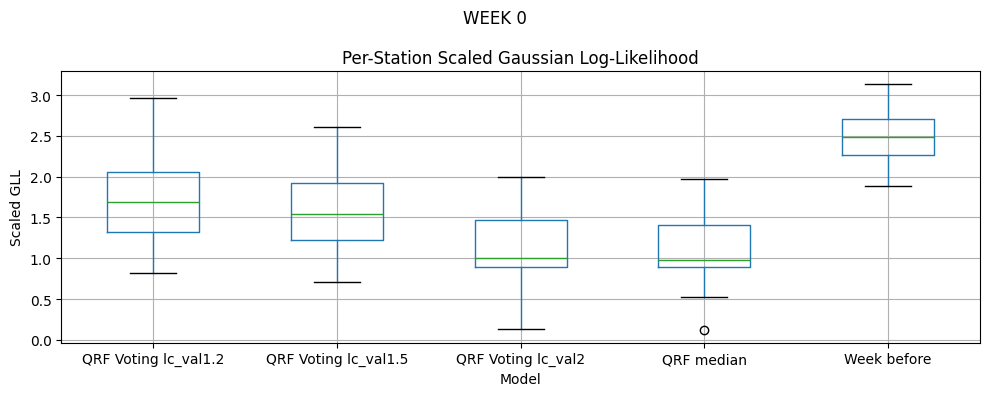

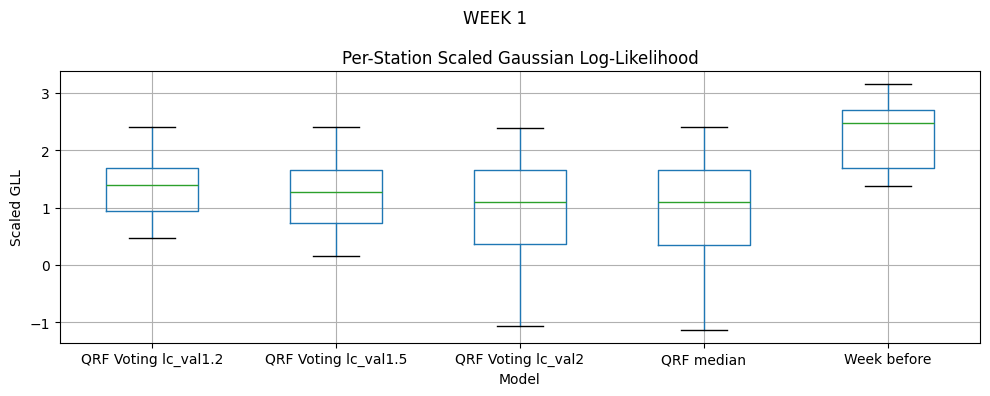

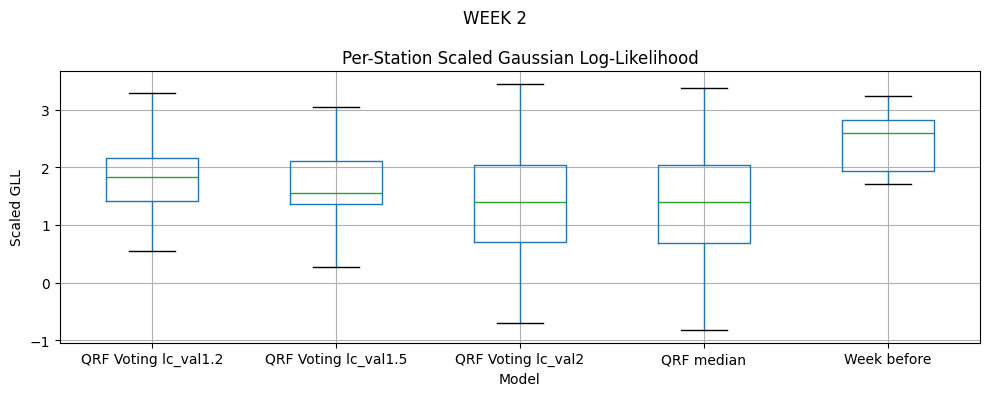

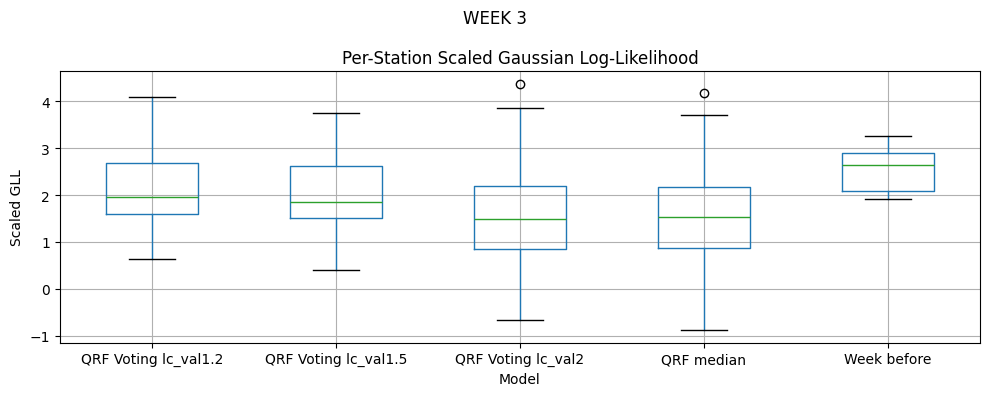

In [149]:
y_train_stations = dataset_train["station_code"].values

X_train_eval = X_train.drop(columns=["station_code"]).fillna(0)

predictions = []

if "chained_qrf" in FINAL_MODELS:
    y_preds_chained_qrf = chained_qrf.predict(X_train_eval, quantiles=[0,0.5, 1])

    for i in range(NUMBER_OF_WEEK):
        y_pis_qrf = np.stack([y_preds_chained_qrf[i][:,0], y_preds_chained_qrf[i][:,2]], axis=1)
        predictions.append({"model": "Chained QRF",
                            "prediction": y_preds_chained_qrf[i][:,1],
                            "dataset":"train",
                            "stations": y_train_stations,
                            "prediction_interval": y_pis_qrf})
        
# if "specialized_qrf" in FINAL_MODELS:
#     y_preds_specialized_qrf = specialized_qrf.predict(X_train_eval)

#     for i in range(NUMBER_OF_WEEK):
#         y_pis_qrf = np.stack([y_preds_specialized_qrf[i][0.05], y_preds_specialized_qrf[i][0.95]], axis=1)
#         predictions.append({"model": "Specialized QRF",
#                             "prediction": y_preds_specialized_qrf[i][0.5],
#                             "dataset":"train",
#                             "stations": y_train_stations,
#                             "prediction_interval": y_pis_qrf})

for i in range(NUMBER_OF_WEEK):
    baseline_day_before = dataset_train["water_flow_lag_1w"]
    predictions.append({"model": "Week before", "prediction": baseline_day_before, "dataset":"train", "stations": y_train_stations, "prediction_interval": None})
    
    # if "qrf_bagging" in FINAL_MODELS:
    #     y_pred_qrf_bagging = np.mean([est.predict(X_train_eval) for est in qrf_bagging[i].estimators_], axis=0)
    #     y_pis_qrf_bagging = np.stack([np.quantile([est.predict(X_train_eval) for est in qrf_bagging[i].estimators_], 0.05, axis=0),
    #                                 np.quantile([est.predict(X_train_eval) for est in qrf_bagging[i].estimators_], 0.95, axis=0)], axis=1)

    #     predictions.append({"model": "QRF bagging",
    #                             "prediction": y_pred_qrf_bagging,
    #                             "dataset":"train",
    #                             "stations": y_train_stations,
    #                             "prediction_interval": y_pis_qrf_bagging})
    if "qrf" in FINAL_MODELS:
        if USE_ONLY_BEST_FEATURES:
            X_train_eval_qrf = X_train_eval[BEST_FEATURES]
        else:
            X_train_eval_qrf = X_train_eval.copy()


        if USE_CORRELATED_FEATURES:
            X_train_eval_qrf = X_train_eval[PERMANENT_FEATURES + correlated_features[f"water_flow_week{i+1}"]]

        y_pred_qrf = qrf[i].predict(X_train_eval_qrf, quantiles=[0.5], aggregate_leaves_first=False)
        y_pis_qrf = qrf[i].predict(X_train_eval_qrf, quantiles=[ALPHA/2, 1-ALPHA/2])
        predictions.append({"model": "QRF median",
                            "prediction": y_pred_qrf,
                            "dataset":"train",
                            "stations": y_train_stations,
                            "prediction_interval": y_pis_qrf})

    if "qrf_voting" in FINAL_MODELS:

        for confidence_value in location_confidences:
            y_preds_voting = preds[confidence_value][i]
            y_pred_qrf_voting = y_preds_voting["mean"]
            y_pis_qrf_voting = np.stack([y_preds_voting["lower"],
                                        y_preds_voting["upper"]], axis=1)

            predictions.append({"model": f"QRF Voting lc_val{confidence_value}",
                                    "prediction": y_pred_qrf_voting,
                                    "dataset":"train",
                                    "stations": y_train_stations,
                                    "prediction_interval": y_pis_qrf_voting})
    if "gpr" in FINAL_MODELS:

        y_preds_gpr = preds[i]
        y_pred_qrf_voting = y_preds_gpr["mean"]
        y_pis_qrf_voting = np.stack([y_preds_gpr["lower"],
                                    y_preds_gpr["upper"]], axis=1)

        predictions.append({"model": f"GPR",
                                "prediction": y_pred_qrf_voting,
                                "dataset":"train",
                                "stations": y_train_stations,
                                "prediction_interval": y_pis_qrf_voting})

    if "quantile_xgb_qrf" in FINAL_MODELS:

        y_pred_xgb_qrf = quantile_xgb_qrf_models[i].predict(X_train_eval)

        y_interval_xgb_qrf = np.stack(
            [
                y_pred_xgb_qrf[:, 0],
                y_pred_xgb_qrf[:, 2],
            ],
            axis=1,
        )

        predictions.append(
            {
                "model": "Quantile-XGB-QRF",
                "prediction": y_pred_xgb_qrf[:, 1],
                "dataset": "train",
                "stations": y_train_stations,
                "prediction_interval": y_interval_xgb_qrf,
            }
        )
    # if "native_xgb_qrf" in FINAL_MODELS:

    #     for i in range(NUMBER_OF_WEEK):
    #         y_pred_xgb_qrf = native_xgb_qrf_models[i].predict(X_train_eval)

    #         y_interval_xgb_qrf = np.stack(
    #             [
    #                 y_pred_xgb_qrf[:, 0],
    #                 y_pred_xgb_qrf[:, 2],
    #             ],
    #             axis=1,
    #         )

    #         predictions.append(
    #             {
    #                 "model": "Native-XGB-QRF",
    #                 "prediction": y_pred_xgb_qrf[:, 1],
    #                 "dataset": "train",
    #                 "stations": y_train_stations,
    #                 "prediction_interval": y_interval_xgb_qrf,
    #             }
    #         )

    if "gbr" in FINAL_MODELS:
        X_train_gbr = X_train.drop(columns=["station_code"])
        y_pred_qrf = gbr[i]["median"].predict(X_train_eval)
        y_pis_qrf = np.stack([gbr[i]["lower"].predict(X_train_eval), gbr[i]["upper"].predict(X_train_eval)], axis=1)
        predictions.append({"model": "GBR",
                            "prediction": y_pred_qrf,
                            "dataset":"train",
                            "stations": y_train_stations,
                            "prediction_interval": y_pis_qrf})
    compare_models_per_station(
        y_train[i].values,
        predictions,
        y_train_stations,
        column_to_display="log_likelihood" ,
        title = f"WEEK {i}")

### 4. Coverage on the Full Training Set

> **Note:**  
> The performance displayed here is calculated on the training set. This does not necessarily reflect the models' performance on unseen data.


In [151]:

if "chained_qrf" in FINAL_MODELS:
    y_preds_chained_qrf = chained_qrf.predict(X_train_eval, quantiles=[0,0.5,1])

    for i in range(NUMBER_OF_WEEK):
        y_pis_qrf = np.stack([y_preds_chained_qrf[i][:,0], y_preds_chained_qrf[i][:,2]], axis=1)
        coverage = (y_train[i].values >= y_pis_qrf[:,0]) & (y_train[i].values <= y_pis_qrf[:,1])
        print(f"Chained QRF coverage of the prediction interval for week {i}: {coverage.mean()}")

# if "specialized_qrf" in FINAL_MODELS:
#     y_preds_spe_qrf = specialized_qrf.predict(X_train_eval)

#     for i in range(NUMBER_OF_WEEK):
#         y_pis_qrf = np.stack([y_preds_spe_qrf[i][0.05], y_preds_spe_qrf[i][0.95]], axis=1)
#         coverage = (y_train[i].values >= y_pis_qrf[:,0]) & (y_train[i].values <= y_pis_qrf[:,1])
#         print(f"Specialized QRF coverage of the prediction interval for week {i}: {coverage.mean()}")

for i in range(NUMBER_OF_WEEK):

    # if "qrf_bagging" in FINAL_MODELS:
    #     y_pred_qrf_bagging = np.mean([est.predict(X_train_eval, quantiles="mean") for est in qrf_bagging[i].estimators_], axis=0)
    #     y_pis_qrf_bagging = np.mean(np.stack(
    #             [
    #                 [
    #                     est.predict(X_train_eval, quantiles=[ALPHA / 2])
    #                     for est in qrf_bagging[i].estimators_
    #                 ],
    #                 [
    #                     est.predict(X_train_eval, quantiles=[ 1 - ALPHA / 2])
    #                     for est in qrf_bagging[i].estimators_
    #                 ]
    #             ],
    #             axis=1,
    #         ), axis=0)
    #     print(y_pred_qrf_bagging.shape)
    #     print(y_pis_qrf_bagging.shape)
    #     coverage = (y_train[i].values >= y_pis_qrf_bagging[0,:]) & (y_train[i].values <= y_pis_qrf_bagging[1,:])
    #     print(f"Bagging QRF coverage of the prediction interval for week {i}: {coverage.mean()}")
    
    if "gbr" in FINAL_MODELS:
        y_pred_gbr = gbr[i]["median"].predict(X_train_eval)
        y_pis_gbr = np.stack([gbr[i]["lower"].predict(X_train_eval), gbr[i]["upper"].predict(X_train_eval)], axis=1)
        coverage = (y_train[i].values >= y_pis_gbr[:,0]) & (y_train[i].values <= y_pis_gbr[:,1])
        print(f"QRF coverage of the prediction interval for week {i}: {coverage.mean()}")
    
    if "gpr" in FINAL_MODELS:
        y_preds_voting = preds[i]
        y_pred_gbr = y_preds_voting["mean"]
        y_pis_gbr = np.stack([y_preds_voting["lower"], y_preds_voting["upper"]], axis=1)
        coverage = (y_train[i].values >= y_pis_gbr[:,0]) & (y_train[i].values <= y_pis_gbr[:,1])
        print(f"GPR coverage of the prediction interval for week {i}: {coverage.mean()}")

    if "qrf" in FINAL_MODELS:

        if USE_CORRELATED_FEATURES:
            X_train_eval_qrf = X_train_eval[PERMANENT_FEATURES + correlated_features[f"water_flow_week{i+1}"]]

        y_pred_qrf = qrf[i].predict(X_train_eval_qrf, quantiles="mean", aggregate_leaves_first=False)
        y_pis_qrf = qrf[i].predict(X_train_eval_qrf, quantiles=[0.05, 0.95])
        coverage = (y_train[i].values >= y_pis_qrf[:,0]) & (y_train[i].values <= y_pis_qrf[:,1])
        print(f"QRF coverage of the prediction interval for week {i}: {coverage.mean()}")

    if "quantile_xgb_qrf" in FINAL_MODELS:
        y_pred_xgb_qrf = quantile_xgb_qrf_models[i].predict(X_train_eval)
        y_interval_xgb_qrf = np.stack(
            [
                quantile_xgb_qrf_models[i].predict(X_train_eval)[:, 0],
                quantile_xgb_qrf_models[i].predict(X_train_eval)[:, 2],
            ],
            axis=1,
        )
        coverage = (y_train[i].values >= y_interval_xgb_qrf[:, 0]) & (
            y_train[i].values <= y_interval_xgb_qrf[:, 1]
        )
        print(
            f"Quantile-XGB-QRF coverage of the prediction interval for week {i}: {coverage.mean()}"
        )

    if "native_xgb_qrf" in FINAL_MODELS:
        y_pred_xgb_qrf = native_xgb_qrf_models[i].predict(X_train_eval)
        y_interval_xgb_qrf = np.stack(
            [
                native_xgb_qrf_models[i].predict(X_train_eval)[:, 0],
                native_xgb_qrf_models[i].predict(X_train_eval)[:, 2],
            ],
            axis=1,
        )
        coverage = (y_train[i].values >= y_interval_xgb_qrf[:, 0]) & (
            y_train[i].values <= y_interval_xgb_qrf[:, 1]
        )
        print(
            f"Native-XGB-QRF coverage of the prediction interval for week {i}: {coverage.mean()}"
        )
        
    if "qrf_voting" in FINAL_MODELS:
        for confidence_value in location_confidences:
            y_preds_voting = preds[confidence_value][i]
            y_pred_gbr = y_preds_voting["mean"]
            y_pis_gbr = np.stack([y_preds_voting["lower"], y_preds_voting["upper"]], axis=1)
            coverage = (y_train[i].values >= y_pis_gbr[:,0]) & (y_train[i].values <= y_pis_gbr[:,1])
            print(f"Voting QRF coverage of the prediction interval for week {i}, lc_val {confidence_value}: {coverage.mean()}")

QRF coverage of the prediction interval for week 0: 0.918850624503646
Voting QRF coverage of the prediction interval for week 0, lc_val 1.2: 0.837845642913869
Voting QRF coverage of the prediction interval for week 0, lc_val 1.5: 0.8750270738574832
Voting QRF coverage of the prediction interval for week 0, lc_val 2: 0.9509782687170601
QRF coverage of the prediction interval for week 1: 0.9162876326619017
Voting QRF coverage of the prediction interval for week 1, lc_val 1.2: 0.801061295213342
Voting QRF coverage of the prediction interval for week 1, lc_val 1.5: 0.849974731066349
Voting QRF coverage of the prediction interval for week 1, lc_val 2: 0.9486679662118258
QRF coverage of the prediction interval for week 2: 0.9049527109955959
Voting QRF coverage of the prediction interval for week 2, lc_val 1.2: 0.786405313695762
Voting QRF coverage of the prediction interval for week 2, lc_val 1.5: 0.8344884845859505
Voting QRF coverage of the prediction interval for week 2, lc_val 2: 0.94170

In [ ]:
import plotly.graph_objects as go
import pandas as pd
import plotly.io as pio

pio.renderers.default = "browser"  # Assure l'affichage en Jupyter

if "qrf" in FINAL_MODELS:
    for i in range(4):
        y_pred_qrf = qrf[i].predict(X_train_eval_qrf, quantiles=[0.5], aggregate_leaves_first=False)
        y_pis_qrf = qrf[i].predict(X_train_eval_qrf, quantiles=[ALPHA/2, 1-ALPHA/2])
        df_plot = pd.DataFrame()
        df_plot["qrf_mean"] = y_pred_qrf
        df_plot["qrf_low"] = y_pis_qrf[:, 0]
        df_plot["qrf_up"] = y_pis_qrf[:, 1]

        print(y_train[i].values)

        df_plot["y_true"] = y_train[i].values

        print(df_plot.isna().sum())     
        t = list(range(len(df_plot)))

        fig = go.Figure()
        print(df_plot["qrf_up"].shape)
        # Courbes des bornes
        fig.add_trace(go.Scatter(
            x=t, y=df_plot["qrf_up"],
            fill=None, mode='lines', line=dict(color='rgba(255,0,0,0.5)'),
            name='Upper Bound'
        ))

        print(df_plot["qrf_low"].shape)
        fig.add_trace(go.Scatter(
            x=t, y=df_plot["qrf_low"],
            fill='tonexty', mode='lines', line=dict(color='rgba(255,0,0,0.5)'),
            name='Lower Bound'
        ))

        print(df_plot["qrf_mean"].shape)
        print(df_plot["y_true"].shape)
        # Courbes des valeurs prédites et réelles
        fig.add_trace(go.Scatter(x=t, y=df_plot["qrf_mean"], mode='lines', name='QRF Mean', line=dict(color='blue')))
        fig.add_trace(go.Scatter(x=t, y=df_plot["y_true"], mode='lines', name='True Values', line=dict(color='green')))

        fig.update_layout(
            title=f'QRF Prediction Interval - Week {i+1}',
            xaxis_title='Index', yaxis_title='Value',
            template='plotly_white',
            xaxis=dict(rangeslider=dict(visible=True)),
            hovermode="x unified"
        )

        fig.show()

        coverage = (y_train[i].values >= y_pis_qrf[:, 0]) & (y_train[i].values <= y_pis_qrf[:, 1])
        print(f"QRF coverage of the prediction interval for week {i}: {coverage.mean():.2%}")


In [ ]:
import plotly.graph_objects as go
import pandas as pd
import plotly.io as pio

pio.renderers.default = "browser"  # Assure l'affichage en Jupyter

if "quantile_xgb_qrf" in FINAL_MODELS:
    for i in range(4):
        y_pred_xgb_qrf = quantile_xgb_qrf_models[i].predict(X_train_eval)
        y_interval_xgb_qrf = np.stack(
            [
                y_pred_xgb_qrf[:, 0],
                y_pred_xgb_qrf[:, 2],
            ],
            axis=1,
        )

        df_plot = pd.DataFrame()
        df_plot["xgb_qrf_mean"] = y_pred_xgb_qrf[:, 1]
        df_plot["xgb_qrf_low"] = y_pred_xgb_qrf[:, 0]
        df_plot["xgb_qrf_up"] = y_pred_xgb_qrf[:, 2]

        print(y_train[i].values)

        df_plot["y_true"] = y_train[i].values

        print(df_plot.isna().sum())     
        t = list(range(len(df_plot)))

        fig = go.Figure()
        print(df_plot["xgb_qrf_up"].shape)
        # Courbes des bornes
        fig.add_trace(go.Scatter(
            x=t, y=df_plot["xgb_qrf_up"],
            fill=None, mode='lines', line=dict(color='rgba(255,0,0,0.5)'),
            name='Upper Bound'
        ))

        print(df_plot["xgb_qrf_low"].shape)
        fig.add_trace(go.Scatter(
            x=t, y=df_plot["xgb_qrf_low"],
            fill='tonexty', mode='lines', line=dict(color='rgba(255,0,0,0.5)'),
            name='Lower Bound'
        ))

        print(df_plot["xgb_qrf_mean"].shape)
        print(df_plot["y_true"].shape)
        # Courbes des valeurs prédites et réelles
        fig.add_trace(go.Scatter(x=t, y=df_plot["xgb_qrf_mean"], mode='lines', name='XGB-QRF Mean', line=dict(color='blue')))
        fig.add_trace(go.Scatter(x=t, y=df_plot["y_true"], mode='lines', name='True Values', line=dict(color='green')))

        fig.update_layout(
            title=f'Quantile-XGB-QRF Prediction Interval - Week {i+1}',
            xaxis_title='Index', yaxis_title='Value',
            template='plotly_white',
            xaxis=dict(rangeslider=dict(visible=True)),
            hovermode="x unified"
        )

        fig.show()

        coverage = (y_train[i].values >= y_interval_xgb_qrf[:, 0]) & (y_train[i].values <= y_interval_xgb_qrf[:, 1])
        print(f"Quantile-XGB-QRF coverage of the prediction interval for week {i}: {coverage.mean():.2%}")

if "native_xgb_qrf" in FINAL_MODELS:
    for i in range(4):
        y_pred_xgb_qrf = native_xgb_qrf_models[i].predict(X_train_eval)
        y_interval_xgb_qrf = np.stack(
            [
                y_pred_xgb_qrf[:, 0],
                y_pred_xgb_qrf[:, 2],
            ],
            axis=1,
        )

        df_plot = pd.DataFrame()
        df_plot["xgb_qrf_mean"] = y_pred_xgb_qrf[:, 1]
        df_plot["xgb_qrf_low"] = y_pred_xgb_qrf[:, 0]
        df_plot["xgb_qrf_up"] = y_pred_xgb_qrf[:, 2]

        print(y_train[i].values)

        df_plot["y_true"] = y_train[i].values

        print(df_plot.isna().sum())     
        t = list(range(len(df_plot)))

        fig = go.Figure()
        print(df_plot["xgb_qrf_up"].shape)
        # Courbes des bornes
        fig.add_trace(go.Scatter(
            x=t, y=df_plot["xgb_qrf_up"],
            fill=None, mode='lines', line=dict(color='rgba(255,0,0,0.5)'),
            name='Upper Bound'
        ))

        print(df_plot["xgb_qrf_low"].shape)
        fig.add_trace(go.Scatter(
            x=t, y=df_plot["xgb_qrf_low"],
            fill='tonexty', mode='lines', line=dict(color='rgba(255,0,0,0.5)'),
            name='Lower Bound'
        ))

        print(df_plot["xgb_qrf_mean"].shape)
        print(df_plot["y_true"].shape)
        # Courbes des valeurs prédites et réelles
        fig.add_trace(go.Scatter(x=t, y=df_plot["xgb_qrf_mean"], mode='lines', name='XGB-QRF Mean', line=dict(color='blue')))
        fig.add_trace(go.Scatter(x=t, y=df_plot["y_true"], mode='lines', name='True Values', line=dict(color='green')))

        fig.update_layout(
            title=f'Native-XGB-QRF Prediction Interval - Week {i+1}',
            xaxis_title='Index', yaxis_title='Value',
            template='plotly_white',
            xaxis=dict(rangeslider=dict(visible=True)),
            hovermode="x unified"
        )

        fig.show()

        coverage = (y_train[i].values >= y_interval_xgb_qrf[:, 0]) & (y_train[i].values <= y_interval_xgb_qrf[:, 1])
        print(f"Native-XGB-QRF coverage of the prediction interval for week {i}: {coverage.mean():.2%}")
